# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

C:\Users\K\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\K\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [2]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

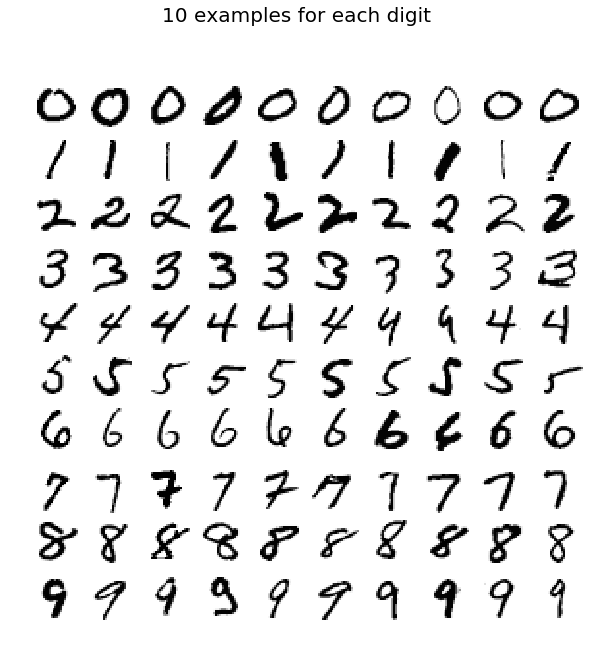

In [3]:
### STUDENT START ###

# 1. create index hash table that stores index of 10 samples for each digit from 0 to 9
def generate_index_table(num_examples, data=train_labels):

    
    # notice num_digits is different thing from num_examples
    num_digits = 10
    
    # create index hash table
    index_dict = {i : [] for i in range(num_digits) }
    complete_count = 0

    # iterate until find all num_digits x num_examples
    for i, label in enumerate(data):

        # store index for the digit(label) if there are less than num_examples
        if len(index_dict[label]) < num_examples:
            index_dict[label].append(i)

            # check if indexing is complete for the digit (label)
            if len(index_dict[label]) == num_examples:
                complete_count += 1

                # stop once it finds num_digits x num_examples
                if complete_count == num_digits:
                    break
                    
    return index_dict

# 2. generate plots
def generate_plot(index_dict, num_digits, num_examples, data_plot = train_data):
    
    
    # create the subplots --- num_digits x num_examples and 10 x 10 grid for each example
    fig, ax = plt.subplots(num_digits, num_examples, figsize = (10, 10))
    
    # iterate by digit and by example
    for digit in range(num_digits):
        for example in range(num_examples):
            idx = index_dict[digit][example]

            # rendering in black and white without axis
            ax[digit, example].imshow(data_plot[idx].reshape(28, 28), cmap = "Greys")
            ax[digit, example].axis('off')

    # add title
    fig.suptitle("{} examples for each digit".format(num_examples), size = 20)  
    fig.subplots_adjust(wspace=.02, hspace=.00)

def P1(num_examples=10):
    
    index_dict = generate_index_table(data=train_labels, num_examples=num_examples)
    
    num_digits = 10
    
    generate_plot(index_dict, num_digits, num_examples)

    
### STUDENT END ###

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [4]:
def P2(k_values):

### STUDENT START ###
    """
    0. iterate k_values
    1. train and predict
    2. create two reports
    """
    import re
    
    # create a hash table to store the prediction performance
    predict_perform = {i: [] for i in k_values}

    # 1. iterate hyperparameter k
    for k in k_values:
        
        # 2. train and predict
        
        # train model
        model = KNeighborsClassifier(n_neighbors = k)
        model.fit(mini_train_data, mini_train_labels)
        
        # predict
        prediction = model.predict(dev_data)
        
        # 3. generate two reports
        
        # generate classification report
        report = classification_report(y_true = dev_labels, y_pred = prediction)
        
        ## 3.1. report for k == 1
        if k == 1:
            print ("      *** Classification Report for K Nearest Neighbor = {} ***\n".format(k))
            print (report)
            
        ## 3.2. prepare summary report
        
        # accuracy
        correct = sum(True if pred == dev_labels[i] else False for i, pred in enumerate(prediction))
        accuracy = correct / len(dev_labels)
#         print (accuracy)
        
        # precision, recall, f1-score from classification report
        
        regex = re.compile(r'avg\s/\stotal\s+(\d\.\d+)\s+(\d\.\d+)\s+(\d\.\d+)')
        match = re.search(regex, report)

        precision, recall, f1 = match.group(1), match.group(2), match.group(3)
        
        predict_perform[k].append( [accuracy, precision, recall, f1] )
        
    # generate summary report
    print ("      *** Summary Report for all selected k_values ***\n")
    print ("                    accuracy   precision   recall  f1-score ")
    for k in k_values:
        print ("k_value = {k}: {a:>15.2f}{p:>10}{r:>10}{ff:>10}".format(
            k=k, a=predict_perform[k][0][0], p=predict_perform[k][0][1], 
            r=predict_perform[k][0][2], ff=predict_perform[k][0][3]))
        
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

      *** Classification Report for K Nearest Neighbor = 1 ***

             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000

      *** Summary Report for all selected k_values ***

                    accuracy   precision   recall  f1-score 
k_value = 1:            0.89      0.89      0.89      0.89
k_value = 3:            0.88      0.89      0.88      0.88
k_value = 5:            0.87      0.88      0.87      0.87
k_v

**ANSWER:**

According to the F1 score, the most difficult digit to predict is 9. And the second most difficult is 3 followed by 2 and 5.

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [5]:
def train_predict(size, k=1, report = True):
    
    # train model
    model = KNeighborsClassifier(n_neighbors= k)
    start = time.time()
    model.fit(train_data[:size], train_labels[:size])
    
    # predict
    prediction = model.predict(dev_data)
    end = time.time()
    
    # record the time
    time_passed = round(end - start, 3)
    
    # calculate accuracy
    correct = sum(True if pred == act else False for pred, act in zip(prediction, dev_labels))
    accuracy = correct / len(dev_labels)
    
    if report:
        import re
        # precision, recall, f1-score from classification report
        classification = classification_report(y_true = dev_labels, y_pred = prediction)
        
        regex = re.compile(r'avg\s/\stotal\s+(\d\.\d+)\s+(\d\.\d+)\s+(\d\.\d+)')
        match = re.search(regex, classification)

        precision = match.group(1)
        recall = match.group(2)
        f1 = match.group(3)
        
        
        print ("Train_size = {s:6}  {a:10.3f}{p:>10}{r:>10}{f:>10}{t:10.2f}s ".format(
            s=size, a=accuracy, p=precision, r=recall, f=f1, t=time_passed ))
  
    return accuracy, time_passed

def P3(train_sizes, accuracies = [], report = True):

    # train and predict
    # then store the results to the hash table
    if report:
            # generate summary report
        print ("\n      *** Summary Report for all the selected train_sizes ***\n")
        print ("                       accuracy  precision   recall   f1-score      time")
    
    for size in train_sizes:
        accuracy, time_passed = train_predict(size)
        accuracies.append(accuracy)
    
    return accuracies

### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = P3(train_sizes)


      *** Summary Report for all the selected train_sizes ***

                       accuracy  precision   recall   f1-score      time
Train_size =    100       0.720      0.77      0.72      0.71      0.16s 
Train_size =    200       0.786      0.80      0.79      0.78      0.29s 
Train_size =    400       0.841      0.85      0.84      0.84      0.59s 
Train_size =    800       0.884      0.89      0.88      0.88      0.99s 
Train_size =   1600       0.902      0.91      0.90      0.90      1.95s 
Train_size =   3200       0.926      0.93      0.93      0.93      4.21s 
Train_size =   6400       0.937      0.94      0.94      0.94      8.25s 
Train_size =  12800       0.959      0.96      0.96      0.96     17.89s 
Train_size =  25000       0.970      0.97      0.97      0.97     36.17s 


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [6]:
def logit_transformation(array):
    return np.log(array / (1 - array))

def un_logit_transformation(array):
    return np.exp(array) / (np.exp(array)  + 1)
    
def P4(train_size, accuracies, test_prediction):

### STUDENT START ###
    ### Without transformation ################
    
    # data preprocessing
    X_train = np.array(train_size).reshape(len(train_size),1) # to matrix
    Y_train = np.array(accuracies)
    X_test = np.array(test_prediction).reshape(len(test_prediction),1)
    
    # train and predict
    model = LinearRegression()
    model.fit(X_train, Y_train)    
    prediction = model.predict(X_test)
    
    print ("{w:>10} Transformation, Predicted Accuracy with Train Size = {s} is {a:>7.2%}".format(
    w = "Without",s= test_prediction[0], a = prediction[0]))
    
    ### With transformation ##################
    Y_train_transformed = logit_transformation(Y_train)
    5
    # train and predict
    model = LinearRegression()
    model.fit(X_train, Y_train_transformed)    
    prediction = model.predict(X_test)
    
    prediction = un_logit_transformation(prediction)
    
    print ("{w:>10} Transformation, Predicted Accuracy with Train Size = {s} is {a:>7.2%}".format(
    w = "With", s= test_prediction[0], a = prediction[0]))

### STUDENT END ###

P4(train_sizes, accuracies, [60000])

   Without Transformation, Predicted Accuracy with Train Size = 60000 is 124.31%
      With Transformation, Predicted Accuracy with Train Size = 60000 is  99.88%


**ANSWER: **

Without the transformation, the predicted accuracy exceeds 100%. Logit transformation and probit transformation are popular to fit the prediction outcome between 0 and 1. I tried logit transformation for this exercise. The model with logit transformation produces the predicted accruacy slightly lower than 100%(1.0).

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

      *** Confusion Matrix ***

[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]






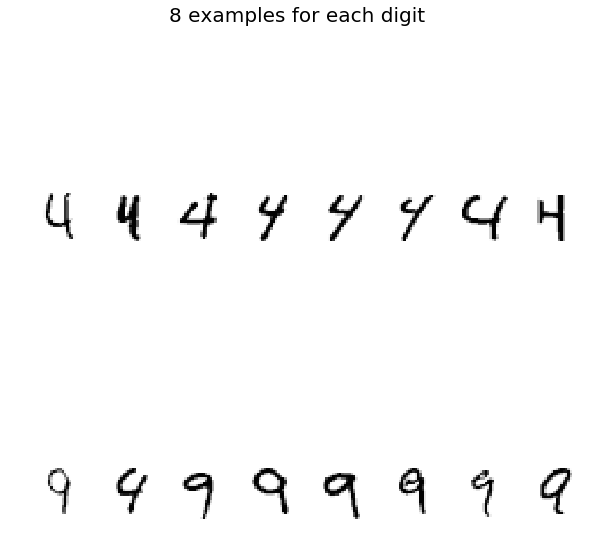

In [7]:
def P5(num_examples = 8):
    ### STUDENT START ###
    
    ### generate confusion matrix ###############################

    # train and predict
    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(mini_train_data, mini_train_labels)
    prediction = model.predict(dev_data)
    
    # generate confusion matrix
    c_matrix = confusion_matrix(y_true=dev_labels, y_pred=prediction, 
                            labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    print ("      *** Confusion Matrix ***\n")
    print (c_matrix)
    
    ### generate index_table ###################################
    # focus on 9 and 4 based on analysis of the confusion matrix
    
    index_dict = {i : [] for i in range(2) }
    
    # get index of samples that are actual 4 but predicted as 9
    act_4_pred_9 = np.where((dev_labels == 4) & (prediction == 9))[0]
    act_9_pred_4 = np.where((dev_labels == 9) & (prediction == 4))[0]

    index_dict[0] = act_4_pred_9[:num_examples]
    index_dict[1] = act_9_pred_4[:num_examples]
    
    ### generate plots #########################################
    
    print ("\n")
    print ("\n")
    
    fig, ax = plt.subplots(2, num_examples, figsize=(10,10))
    
#     fig.set_aspect('equal')
    
    for i in range(2):
        for j in range(num_examples):      
            ax[i,j].imshow(dev_data[index_dict[i][j]].reshape(28,28), cmap = "Greys")
            ax[i,j].axis('off')
            
    fig.subplots_adjust(wspace=0.1, hspace=0.01)
    fig.suptitle("{} examples for each digit".format(num_examples), size = 20)
    
    
### STUDENT END ###

P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [8]:
def gaussianBlur(matrix, sd = 2, r = 1):
    """
    Input: matrix, sd (standard deviation), r = blur range
    Output: matrix after gaussian blur
    refer: http://blog.ivank.net/fastest-gaussian-blur.html
    
    """
    # initalize
    h, w = matrix.shape
    output = np.zeros_like(matrix)
    
    # iterate through matrix
    for i in range(h):
        for j in range(w):
            val = 0
            wsum = 0
            
            # get the jitters
            rows = range( max(0, i - r), min(h, i + r + 1))
            cols = range( max(0, j - r), min(w, j + r + 1))
            
            # iterate through jitters around the target
            for iy in rows:
                for ix in cols:
                    
                    dsq = (ix -j) **2 + (iy -i)**2
                    wght = (np.exp( -1.0 * dsq / (2 * sd**2)))  / (2 * np.pi * sd**2)
                    
                    val += matrix[iy, ix] * wght
                    wsum += wght
            
            # write the result
            output[i, j] = round(val/wsum, 4)
            
    return output

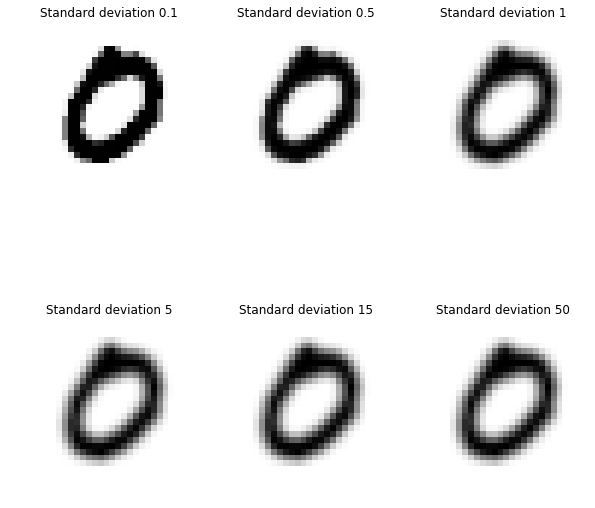

In [9]:
sample = test_data[1].reshape(28, 28)
def test_gaussianBlur(sample, sds = [0.1, 0.5, 1, 5, 15, 50], r = 1, row = 2, col = 3):
    
    fix, ax = plt.subplots(row,col, figsize=(10,10))
    for i, sd in enumerate(sds):
        j = i % col 
        i = i // col
        
        blurred = gaussianBlur(sample, sd = sd)
        ax[i,j].imshow(blurred, cmap = "Greys")
        ax[i,j].set_title("Standard deviation {}".format(sd))
        ax[i,j].axis('off')

test_gaussianBlur(sample)

In [10]:
def P6(blur_train = True, blur_dev = True):
    
### STUDENT START ###
    start = time.time()
    
    #### get the data-set ready
    if blur_train:
        train = np.apply_along_axis( lambda x: gaussianBlur( x.reshape(28,28) ).flatten(), 1 , mini_train_data)
    else:
        train = mini_train_data
        
    if blur_dev:
        dev = np.apply_along_axis( lambda x: gaussianBlur( x.reshape(28,28) ).flatten(), 1 , dev_data)
    else:
        dev = dev_data
    
    #### train, predict
    m = KNeighborsClassifier(n_neighbors=1)
    m.fit(train, mini_train_labels)
    predicted = m.predict(dev)
    
    end = time.time()
    elapsed = end - start
    elapsed = str(elapsed).split('.')
    
    #### print the result
    correct = sum([ i == j for i,j in zip(predicted, dev_labels) ])
    accuracy = 1. * correct / len(dev_labels)
    
    print ('{tr:^16}    {dv:^12}      {a:.1%}   {t[0]:>2}.{t[1]:.2}s'.format(
        tr= 'ON' if blur_train else 'OFF',
        dv= 'ON' if blur_dev else 'OFF',
        a=accuracy, t=elapsed ) )

### STUDENT END ###

print ('Blurred Training    Blurred Dev    Accuracy    Time')
P6(blur_train=False, blur_dev=False)
P6(blur_train=False, blur_dev=True)
P6(blur_train=True, blur_dev=False)
P6(blur_train=True, blur_dev=True)


Blurred Training    Blurred Dev    Accuracy    Time
      OFF               OFF           88.8%    1.55s
      OFF                ON           87.3%   30.96s
       ON               OFF           91.0%   29.26s
       ON                ON           90.2%   58.74s


**ANSWER:**

The results show that blurring the train data best improves accuracy. It is also observed that not smoothing the dev data contributes better accuracy.

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [11]:
def mapping(dataset, thresholds = [.5]):
    
    result = np.apply_along_axis(lambda x: np.digitize(x, thresholds), 1, dataset)
    
    return result

def P7(thresholds):

### STUDENT START ###
    start = time.time()
    
    # select model
    if len(thresholds) == 1:
        m = BernoulliNB(alpha = 1., fit_prior=False)
    else:
        m = MultinomialNB(alpha = 1., fit_prior=False)
        
    # train and predict
    m.fit(mapping(mini_train_data, thresholds=thresholds), mini_train_labels)
    prediction = m.predict( mapping(dev_data, thresholds=thresholds))
    
    end = time.time()
    elapsed = end - start
    elapsed = str(elapsed).split('.')
    
    # print the result
    correct = sum([ i == j for i,j in zip(prediction, dev_labels) ])
    accuracy = 1. * correct / len(dev_labels)
    
    
    print ('{m:^16}  {th:^12}    {a:.1%}   {tm[0]:>2}.{tm[1]:.3}s'.format(
        m='BernoulliNB' if len(thresholds) == 1 else 'MultinomialNB',
        th=str(thresholds), a=accuracy, tm= elapsed) )
    
### STUDENT END ###

print ('{:^16}  Threshold(s)  Accuracy    Time'.format('MODEL'))
P7([.3])
P7([.5])
P7([.7])
P7([.2, .8])
P7([.33, .66])
P7([.4, .6])
P7([.4, .5])

     MODEL        Threshold(s)  Accuracy    Time
  BernoulliNB        [0.3]        81.7%    0.055s
  BernoulliNB        [0.5]        81.5%    0.061s
  BernoulliNB        [0.7]        80.4%    0.063s
 MultinomialNB     [0.2, 0.8]     79.7%    0.038s
 MultinomialNB    [0.33, 0.66]    80.1%    0.031s
 MultinomialNB     [0.4, 0.6]     80.0%    0.040s
 MultinomialNB     [0.4, 0.5]     79.9%    0.038s


**ANSWER:**

BernoulliNB vs. MultinomialNB: For this problem, the simpler model, BernoulliNB, performed better than than the more complex model multinomialNB. I think grey class doesn't carry information because both narrower and wider bounds for grey class produce similar accuracy.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [12]:
def P8(alphas):
    
### STUDENT START ###

    m = BernoulliNB(binarize=0.3, fit_prior=False)
    gsearch = GridSearchCV(m, alphas)
    gsearch.fit(mini_train_data, mini_train_labels)
        
    return gsearch

### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

print ('ALPHA   AVG-Score    SCORES')
for row in nb.grid_scores_:
    print ("{0[alpha]:<6}   {1:5.1%}   [ {2[0]:5.1%}, {2[1]:5.1%}, {2[2]:5.1%} ]".format(*row))

C:\Users\K\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\K\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\K\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:820: RuntimeWarning: divide by zero encountered in log
  neg_prob = np.log(1 - np.exp(self.feature_log_prob_))
C:\Users\K\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:801: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


ALPHA   AVG-Score    SCORES
0.0       9.2%   [  9.2%,  9.3%,  9.1% ]
0.0001   82.3%   [ 84.0%, 81.4%, 81.5% ]
0.001    82.7%   [ 84.3%, 82.0%, 81.8% ]
0.01     82.9%   [ 84.3%, 82.6%, 81.8% ]
0.1      82.1%   [ 84.0%, 80.8%, 81.5% ]
0.5      81.3%   [ 83.1%, 80.8%, 79.9% ]
1.0      81.0%   [ 82.0%, 81.7%, 79.3% ]
2.0      79.8%   [ 81.4%, 79.6%, 78.4% ]
10.0     74.2%   [ 76.0%, 72.7%, 73.9% ]


In [13]:
#print nb.best_params_
print ('Best alpha for BernoulliNB is ')
print (nb.best_params_)

Best alpha for BernoulliNB is 
{'alpha': 0.01}


**ANSWER:**

Alpha 0.01 produces the best scores. Alpha 0 has very low scores. This is not a surprise because without smoothing parameters would end up 0 and thus produces poor prediction results.

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [14]:
def baseline_BernoulliNB():
    # train the model
    m = BernoulliNB(binarize=0.3, alpha = 0.01, fit_prior=False)
    m.fit(mini_train_data, mini_train_labels)
    prediction = m.predict(dev_data)
    
    # print the result
    correct = sum([ i == j for i,j in zip(prediction, dev_labels) ])
    accuracy = 1. * correct / len(dev_labels)
    
    print ("--- BernoulliNB: Prediction accuracy {:5.1%}\n".format(accuracy))
    
def baseline_GaussianNB():
    # train the model
    m = GaussianNB()
    m.fit(mini_train_data, mini_train_labels)
    prediction = m.predict(dev_data)
    
    # print the result
    correct = sum([ i == j for i,j in zip(prediction, dev_labels) ])
    accuracy = 1. * correct / len(dev_labels)
    
    print ("--- GaussianNB: Prediction accuracy {:5.1%}\n".format(accuracy))
    print ("GaussianNB parameters\n")
    print ('theta: {t}\n sigma: {s}\n'.format(t= m.theta_,s= m.sigma_))

    
def sigma_fix_GaussianNB():
    # train the model
    m = GaussianNB()
    m.fit(mini_train_data, mini_train_labels)
    
    # fix sigma = 1
    m.sigma_ = np.ones_like(m.sigma_)
    
    # print the result
    prediction = m.predict(dev_data)
    correct = sum([ i == j for i,j in zip(prediction, dev_labels) ])
    accuracy = 1. * correct / len(dev_labels)
    
    print ("--- GaussianNB + Fixed Sigma 1: Prediction accuracy {:5.1%}\n".format(accuracy))
    
    
def P9():

### STUDENT END ###

    baseline_BernoulliNB()    
    baseline_GaussianNB()
    sigma_fix_GaussianNB()

### STUDENT END ###

P9()

--- BernoulliNB: Prediction accuracy 82.1%

--- GaussianNB: Prediction accuracy 62.1%

GaussianNB parameters

theta: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
 sigma: [[  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 ..., 
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-

**ANSWER:**

Fixing sigma = 1 solves the problem. With that simple fix accuracy score for GaussianNB move up from 62.1% to 80.2%. This is because original GaussianNB have sigma close to 0 that does not play well with the Gaussian's forumala. Large number of zero color is causing this issue.

We can also take different approach here to improve GaussianNB's accuracy. By adding a random noise coming from the normal distribution to the dataset should improve the accuracy. Also, blurring which raises the variability of the features would increase the accuracy. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

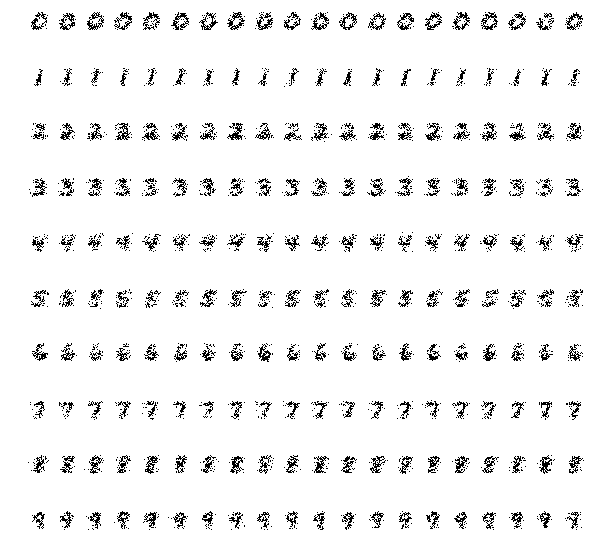

In [15]:
def P10(num_examples, num_digits = 10):

### STUDENT START ###
    # train the model
    m = BernoulliNB(binarize=0.3, alpha = 0.01, fit_prior=False)
    m.fit(mini_train_data, mini_train_labels)
    
    # plot
    fig, ax = plt.subplots(num_digits, num_examples, figsize= (10, 10))
    for num in range(num_digits):
        for j in range(num_examples):
            
            # generate example by the trained model
            example = (np.random.rand(784) < np.exp(m.feature_log_prob_[num])).reshape(28,28)
            
            ax[num, j].imshow(example, cmap = "Greys")
            ax[num, j].axis('off')
            

### STUDENT END ###

P10(20)

**ANSWER:**

The NB model produced much more blurry digit images than digits in the training data.  

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [16]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    # fit the model
    m = BernoulliNB(alpha = 0.01, binarize = .3, fit_prior=False)
    m.fit(mini_train_data, mini_train_labels)
    
    # predict
    pred_prob = np.exp( m.predict_log_proba(dev_data) )
    posterior_prob = np.max(pred_prob, axis=1)
    predicted_label = np.argmax(pred_prob, axis=1)
    
    # iterate all the predctions
    for i, prob in enumerate(posterior_prob):
        for j, bucket in enumerate(buckets):
            if prob >= bucket:
                
                # count
                total[j] += 1
                
                # check if correct
                if predicted_label[i] == dev_labels[i]:
                    correct[j] += 1
                    
                
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total = 998    accuracy = 0.823
p(pred) <= 0.9000000000000    total = 955    accuracy = 0.844
p(pred) <= 0.9990000000000    total = 882    accuracy = 0.881
p(pred) <= 0.9999900000000    total = 818    accuracy = 0.899
p(pred) <= 0.9999999000000    total = 759    accuracy = 0.920
p(pred) <= 0.9999999990000    total = 695    accuracy = 0.941
p(pred) <= 0.9999999999900    total = 637    accuracy = 0.950
p(pred) <= 0.9999999999999    total = 573    accuracy = 0.962
p(pred) <= 1.0000000000000    total = 551    accuracy = 0.966


**ANSWER:**

It seems the classifier is weakly calibarted since there is positive correlation between posterior probability and accuracy.

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [17]:
### STUDENT START ###

def add_colrow_sums(data):
    
    # initialize
    num_examples = data.shape[0]
    new_features = np.zeros((num_examples, 2 * 28))
    
    # compute row/col sums
    for i, digit in enumerate(data):
        row_sum = np.sum(digit.reshape(28, 28), axis = 1)
        col_sum = np.sum(digit.reshape(28, 28), axis = 0)
        new_features[i] = np.append(row_sum, col_sum)
        
    # min-max normalize
    new_features = (new_features - np.amin(new_features))/ (np.amax(new_features) - np.amin(new_features))
    
    return np.hstack((data, new_features))

def P12():
    # call baseline prediction for comparison
    baseline_BernoulliNB()
    
    # set-up
    mini_train_data_sums = add_colrow_sums(mini_train_data)
    dev_data_sums = add_colrow_sums(dev_data)
    
    m = BernoulliNB(alpha = 0.01, binarize=0.3, fit_prior=False)
    m.fit(mini_train_data_sums, mini_train_labels)
    
    prediction = m.predict(dev_data_sums)
    
    # print the result
    correct = sum([ i == j for i,j in zip(prediction, dev_labels) ])
    accuracy = 1. * correct / len(dev_labels)    
    
    print ("--- BernoulliNB + Sum Features: Prediction accuracy {:5.1%}\n".format(accuracy))
    

### STUDENT END ###

P12()

--- BernoulliNB: Prediction accuracy 82.1%

--- BernoulliNB + Sum Features: Prediction accuracy 82.8%



**ANSWER:**
    
New features that are column sum and row sum are introduced to the model. As a result, the model accuracy improves from 82.1% to 82.8% holding other things constant.